[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/06_area_zonal_stats.ipynb)

In [ ]:
#| default_exp area_zonal_stats

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| export
from typing import Any, Dict, List

import geopandas as gpd
import numpy as np
import geowrangler.vector_zonal_stats as vzs
from geowrangler.vector_zonal_stats import GEO_INDEX_NAME

In [ ]:
#| include: false
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [ ]:
#| exporti
def extract_func(func):
    # extra by default is none
    extra = []
    # extra can contain either raw, data or aoi
    if func.__contains__("raw_"):
        extra += ["raw"]
        func = func.replace("raw_", "")
    elif func.__contains__("data_"):
        extra += ["data"]
        func = func.replace("data_", "")
    elif func.__contains__("aoi_"):
        extra += ["aoi"]
        func = func.replace("aoi_", "")
    # extra can have imputed
    if func.__contains__("imputed_"):
        extra += ["imputed"]
        func = func.replace("imputed_", "")

    return func, extra

In [ ]:
#| include: false
assert extract_func("count") == ("count", [])
assert extract_func("raw_count") == ("count", ["raw"])
assert extract_func("imputed_count") == ("count", ["imputed"])
assert extract_func("raw_imputed_count") == ("count", ["raw", "imputed"])
assert extract_func("aoi_count") == ("count", ["aoi"])
assert extract_func("aoi_imputed_count") == ("count", ["aoi", "imputed"])
assert extract_func("data_count") == ("count", ["data"])
assert extract_func("data_imputed_count") == ("count", ["data", "imputed"])

In [ ]:
#| exporti


def fix_area_agg(agg):
    if "func" not in agg:
        return agg  # skip fix as agg spec is invalid

    if type(agg["func"]) == str:
        agg["func"] = [agg["func"]]

    real_funcs = []
    func_extras = []
    for func in agg["func"]:
        real_func, extra = extract_func(func)
        real_funcs += [real_func]
        func_extras += [extra]
    agg["func"] = real_funcs
    agg["extras"] = func_extras

    agg = vzs._fix_agg(agg)

    return agg

In [ ]:
#| include: false
assert fix_area_agg(dict(func="count")) == dict(
    func=["count"],
    column=GEO_INDEX_NAME,
    output=["index_count"],
    fillna=[False],
    extras=[[]],
)

In [ ]:
#| include: false
assert fix_area_agg(
    dict(
        func=["count", "sum"],
        column="population",
        output=["samples", "population"],
        fillna=[True, True],
    )
) == dict(
    func=["count", "sum"],
    column="population",
    output=["samples", "population"],
    fillna=[True, True],
    extras=[[], []],
)

In [ ]:
#| exporti


def get_source_column(agg):

    if "raw" in agg["extras"]:
        return agg["column"]  # dont use intersect column

    intersect_data_column = f"intersect_data_{agg['column']}"
    intersect_aoi_column = f"intersect_aoi_{agg['column']}"

    if "data" in agg["extras"]:
        return intersect_data_column

    if "aoi" in agg["extras"]:
        return intersect_aoi_column
    # defaults if not overridden by extra modifier
    if agg["func"] == "sum":  # sum apportions data area
        return intersect_data_column
    if agg["func"] == "mean":  # mean apportions on aoi area
        return intersect_aoi_column
    return agg["column"]  # everything else based on raw column

In [ ]:
#| include: false
assert (
    get_source_column(dict(func="count", column="population", extras=[]))
    == "population"
)
assert (
    get_source_column(dict(func="count", column="population", extras=["raw"]))
    == "population"
)
assert (
    get_source_column(dict(func="sum", column="population", extras=[]))
    == "intersect_data_population"
)
assert (
    get_source_column(dict(func="mean", column="internet_speed", extras=[]))
    == "intersect_aoi_internet_speed"
)
assert (
    get_source_column(dict(func="mean", column="population", extras=["raw"]))
    == "population"
)

In [ ]:
#| exporti
INTERSECT_AREA_AGG = {
    "column": "intersect_area",
    "func": "sum",
    "output": "intersect_area_sum",
    "extras": "raw",
}

In [ ]:
#| exporti
def build_agg_area_dicts(aggs):
    aggs = [INTERSECT_AREA_AGG, *aggs]
    agg_dicts = {agg["output"]: (get_source_column(agg), agg["func"]) for agg in aggs}
    return agg_dicts

In [ ]:
#| include: false
input_aggs = [
    {
        "column": GEO_INDEX_NAME,
        "func": "count",
        "output": f"{GEO_INDEX_NAME}_count",
        "extras": ["raw"],
    },
    {"column": "population", "func": "sum", "output": "population_sum", "extras": []},
    {
        "column": "internet_speed",
        "func": "mean",
        "output": "internet_speed_mean",
        "extras": [],
    },
    {
        "column": "internet_speed",
        "func": "mean",
        "output": "internet_speed_imputed_mean",
        "extras": [
            "imputed",
        ],
    },
]

In [ ]:
#| include: false
assert build_agg_area_dicts(input_aggs) == {
    f"{GEO_INDEX_NAME}_count": (f"{GEO_INDEX_NAME}", "count"),
    "intersect_area_sum": ("intersect_area", "sum"),
    "population_sum": ("intersect_data_population", "sum"),
    "internet_speed_mean": ("intersect_aoi_internet_speed", "mean"),
    "internet_speed_imputed_mean": ("intersect_aoi_internet_speed", "mean"),
}

In [ ]:
#| exporti


def validate_area_aoi(aoi):
    if aoi.crs.is_geographic:
        raise ValueError(
            f"aoi has geographic crs: {aoi.crs}, areas maybe incorrectly computed"
        )

In [ ]:
#| exporti


def validate_area_data(data):
    if data.crs.is_geographic:
        raise ValueError(
            f"data has geographic crs: {data.crs}, areas maybe incorrectly computed"
        )

In [ ]:
#| exporti


def expand_area_aggs(aggs):
    expanded_aggs = []
    for agg in aggs:
        for i, func in enumerate(agg["func"]):
            expanded_agg = {
                "func": func,
                "column": agg["column"],
                "output": agg["output"][i],
                "fillna": agg["fillna"][i],
                "extras": agg["extras"][i],
            }
            expanded_aggs += [expanded_agg]
    return expanded_aggs

In [ ]:
#| exporti
def compute_intersect_stats(intersect, expanded_aggs):
    # optimization - use df.apply to create all new columns simultaneously
    for agg in expanded_aggs:
        if "raw" in agg["extras"]:
            continue  # skip intersect stat
        intersect_data_column = f"intersect_data_{agg['column']}"
        intersect_aoi_column = f"intersect_aoi_{agg['column']}"
        if intersect_data_column not in intersect.columns.values:
            intersect[intersect_data_column] = (
                intersect["pct_data"] * intersect[agg["column"]]
            )
        if intersect_aoi_column not in intersect.columns.values:
            intersect[intersect_aoi_column] = (
                intersect["pct_aoi"] * intersect[agg["column"]]
            )
    return intersect

In [ ]:
#| exporti
def compute_imputed_stats(results, expanded_aggs):
    # optimize with df.apply
    # handle when intersect_area_sum is np.nan
    for agg in expanded_aggs:
        if "imputed" in agg["extras"]:
            results[agg["output"]] = (
                results[agg["output"]] * results["aoi_area"]
            ) / results[INTERSECT_AREA_AGG["output"]]

    return results

In [ ]:
#| export
def create_area_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf of region/areas containing data to compute zonal stats from
    aggregations: List[  # List of agg specs, with each agg spec applied to a data column
        Dict[str, Any]
    ] = [],
    include_intersect=True,  # Add column 'intersect_area_sum' w/ch computes total area of data areas intersecting aoi
    fix_min=True,  # Set min to zero if there are areas in aoi w/ch do not containing any intersecting area from the data.
):

    validate_area_aoi(aoi)
    validate_area_data(data)

    fixed_aggs = [fix_area_agg(agg) for agg in aggregations]

    # validate_area_aggs(fixed_aggs,data)
    vzs._validate_aggs(fixed_aggs, data)

    # reindex aoi
    aoi_index_name = aoi.index.name
    aoi = vzs._prep_aoi(aoi)
    data = data.copy()

    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # compute aoi and data areas
    aoi["aoi_area"] = aoi.geometry.area
    data["data_area"] = data.geometry.area

    # add spatial indexes
    aoi.geometry.sindex
    data.geometry.sindex

    intersect = aoi.overlay(data, keep_geom_type=True)

    # compute intersect area and percentages
    intersect["intersect_area"] = intersect.geometry.area
    intersect["pct_data"] = intersect["intersect_area"] / intersect["data_area"]
    intersect["pct_aoi"] = intersect["intersect_area"] / intersect["aoi_area"]

    expanded_aggs = expand_area_aggs(fixed_aggs)
    intersect = compute_intersect_stats(intersect, expanded_aggs)

    groups = intersect.groupby(GEO_INDEX_NAME)

    agg_area_dicts = build_agg_area_dicts(expanded_aggs)

    aggregates = groups.agg(**agg_area_dicts)
    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )

    bool_mask = INTERSECT_AREA_AGG["output"] 
    results[bool_mask] = results[bool_mask].fillna(value=0.0)
    # set min to zero if intersect area is not filled.
    if fix_min:
        for col, val in agg_area_dicts.items():
            if val[1] == "min":
                results[col] = results.apply(
                    lambda x, c: x[c]
                    if np.isclose(x["aoi_area"], x[INTERSECT_AREA_AGG["output"]])
                    else 0.0,
                    axis=1,
                    c=col,  # kwarg to pass to lambda
                )
    results = compute_imputed_stats(results, expanded_aggs)
    results = vzs._fillnas(expanded_aggs, results, aoi)
    drop_labels = ["aoi_area"]
    if not include_intersect:
        drop_labels += [INTERSECT_AREA_AGG["output"]]
    results = results.drop(labels=drop_labels, axis=1)

    results = results.set_index(GEO_INDEX_NAME)
    results.index.name = aoi_index_name
    return results

## Test data

### Simple squares

In [ ]:
#| include: false
def square(x, y, size=1):
    return Polygon([(x, y), (x, size + y), (size + x, size + y), (size + x, y)])

In [ ]:
#| include: false
def make_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            square(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [ ]:
#| include: false
simple_aoi = make_df(5, 1, has_internet=False, has_population=False, offset_x=0.0)
simple_data = make_df(3, 1)

Given an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`)

In [ ]:
simple_aoi

,geometry
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))"
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))"
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))"
3,"POLYGON ((3 0, 3 1, 4 1, 4 0, 3 0))"
4,"POLYGON ((4 0, 4 1, 5 1, 5 0, 4 0))"


In [ ]:
simple_data

,geometry,population,internet_speed
0,"POLYGON ((0.25 0, 0.25 1, 1.25 1, 1.25 0, 0.25...",100,20.0
1,"POLYGON ((1.25 0, 1.25 1, 2.25 1, 2.25 0, 1.25...",200,10.0
2,"POLYGON ((2.25 0, 2.25 1, 3.25 1, 3.25 0, 2.25...",300,5.0


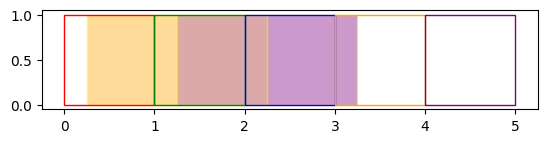

In [ ]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(
    ax=ax, facecolor="none", edgecolor=["r", "g", "b", "orange", "purple"]
)

The red,green,blue, orange and purple outlines are the 5 regions of interest (aoi) while the orange,brown, purple areas are the data areas. 

In [ ]:
empty_aoi_results = create_area_zonal_stats(simple_aoi, simple_data)

In [ ]:
empty_aoi_results

,geometry,intersect_area_sum
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",0.75
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1.00
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1.00
3,"POLYGON ((3 0, 3 1, 4 1, 4 0, 3 0))",0.25
4,"POLYGON ((4 0, 4 1, 5 1, 5 0, 4 0))",0.00


In [ ]:
%%time
simple_aoi_results = create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func="count", output="sample_count"),
        dict(func=["sum", "count"], column="population"),
        dict(func=["mean", "max", "min", "std"], column="internet_speed"),
    ],
)

CPU times: user 11.3 ms, sys: 1.23 ms, total: 12.5 ms
Wall time: 12.9 ms


In [ ]:
simple_aoi_results

,geometry,intersect_area_sum,sample_count,population_sum,population_count,internet_speed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",0.75,1.0,75.0,1.0,15.000,20.0,0.0,NaN
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1.00,2.0,175.0,2.0,6.250,20.0,10.0,7.071068
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1.00,2.0,275.0,2.0,3.125,10.0,5.0,3.535534
3,"POLYGON ((3 0, 3 1, 4 1, 4 0, 3 0))",0.25,1.0,75.0,1.0,1.250,5.0,0.0,NaN
4,"POLYGON ((4 0, 4 1, 5 1, 5 0, 4 0))",0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [ ]:
simple_aoi_results.population_sum.sum(axis=None)

np.float64(600.0)

In [ ]:
%%time
corrected_aoi_results = create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population"),
        dict(
            func=["mean", "imputed_mean", "raw_max", "raw_min", "raw_std"],
            column="internet_speed",
            output=[
                "internet_speed_mean",
                "internet_speed_imputed_mean",
                "internet_speed_max",
                "internet_speed_min",
                "internet_speed_std",
            ],
        ),
    ],
    fix_min=False,
)

CPU times: user 11.7 ms, sys: 849 µs, total: 12.5 ms
Wall time: 12.1 ms


In [ ]:
corrected_aoi_results

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_imputed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",0.75,75.0,1.0,15.000,20.000,20.0,20.0,NaN
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1.00,175.0,2.0,6.250,6.250,20.0,10.0,7.071068
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1.00,275.0,2.0,3.125,3.125,10.0,5.0,3.535534
3,"POLYGON ((3 0, 3 1, 4 1, 4 0, 3 0))",0.25,75.0,1.0,1.250,5.000,5.0,5.0,NaN
4,"POLYGON ((4 0, 4 1, 5 1, 5 0, 4 0))",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
aois_no_nas = create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population", fillna=[True, True]),
        dict(
            func=["mean", "imputed_mean", "raw_max", "raw_min", "raw_std"],
            column="internet_speed",
            output=[
                "internet_speed_mean",
                "internet_speed_imputed_mean",
                "internet_speed_max",
                "internet_speed_min",
                "internet_speed_std",
            ],
            fillna=[True, True, True, True, True],
        ),
    ],
    fix_min=False,
)

CPU times: user 12.1 ms, sys: 679 µs, total: 12.8 ms
Wall time: 12.3 ms


In [ ]:
aois_no_nas

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_imputed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",0.75,75.0,1.0,15.000,20.000,20.0,20.0,0.000000
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1.00,175.0,2.0,6.250,6.250,20.0,10.0,7.071068
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1.00,275.0,2.0,3.125,3.125,10.0,5.0,3.535534
3,"POLYGON ((3 0, 3 1, 4 1, 4 0, 3 0))",0.25,75.0,1.0,1.250,5.000,5.0,5.0,0.000000
4,"POLYGON ((4 0, 4 1, 5 1, 5 0, 4 0))",0.00,0.0,0.0,0.000,0.000,0.0,0.0,0.000000
